# E-commerce Data Exploration and Analysis
## Introduction:
In this project, we are going to delve into the fascinating world of e-commerce, focusing on understanding the patterns, preferences, and peculiarities of [online shopping behavior in Brazil from 2016 to 2018](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=product_category_name_translation.csv). Through an extensive analysis of diverse datasets, we aim to uncover insights into product popularity, sales trends, payment methods, and more, utilizing Python's Pandas library to manage, manipulate, and analyze the data.

## Step 1: Data Collection & Initial Exploration
As the first step, we'll load the relevant datasets into Pandas dataframes. We'll then proceed to conduct a preliminary exploration to understand the datasets better, including their structure, data types, and potential missing values. This understanding is crucial for making informed decisions in the following steps of our analysis.

**Action plan:**
- Load the datasets.
- Translate product categories to English.
- Conduct initial exploration: utilize `info()`, `head()`, and `describe()` to understand the data.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from scipy import stats

In [42]:
# Load the datasets
df_customers = pd.read_csv('data/olist_customers_dataset.csv')
df_items = pd.read_csv('data/olist_order_items_dataset.csv')
df_payment = pd.read_csv('data/olist_order_payments_dataset.csv')
df_orders = pd.read_csv('data/olist_orders_dataset.csv')
df_products = pd.read_csv('data/olist_products_dataset.csv')
df_sellers = pd.read_csv('data/olist_sellers_dataset.csv')
df_translation = pd.read_csv('data/product_category_name_translation.csv')

# Translate product category names to English
df_products = df_products.merge(df_translation, on='product_category_name', how='left')
df_products.drop(columns=['product_category_name'], inplace=True)
df_products.rename(columns={'product_category_name_english': 'product_category_name'}, inplace=True)

# EDA
dataframes = {
    'df_customers': df_customers, 
    'df_items': df_items, 
    'df_payment': df_payment, 
    'df_orders': df_orders, 
    'df_products': df_products, 
    'df_sellers': df_sellers
}

for name, df in dataframes.items():
    print(f'{name}:\n')
    print(df.info())
    print(df.head(3))
    print(df.describe())
    print("\n----------------------------------------\n")


df_customers:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1              

At this point we can notice the following about these dataframes:

#### `df_customers`:
- **Contains**: Customer details including IDs, zip code prefix, city, and state.
- **Null Values**: No null values in any of the columns.
- **Notes**: 
    - The `customer_zip_code_prefix` varies greatly, indicating a wide geographical distribution of customers.

#### `df_items`:
- **Contains**: Information about items in the orders such as order ID, product ID, seller ID, price, and freight value.
- **Null Values**: No null values in any of the columns.
- **Notes**: 
    - The `price` ranges from 0.85 to 6735, indicating a wide range of product prices.
    - The `freight_value` also varies greatly, from 0 to approximately 409.68.
    - Majority of the orders contain only one item (`order_item_id` is mostly 1).

#### `df_payment`:
- **Contains**: Payment details including order ID, payment sequential, payment type, payment installments, and payment value.
- **Null Values**: No null values in any of the columns.
- **Notes**: 
    - Payment values (`payment_value`) have a large range, from 0 to 13664.08, highlighting different order values.
    - Most orders are single-payment transactions, as indicated by the `payment_sequential` mostly being 1.

#### `df_orders`:
- **Contains**: Order details including order IDs, customer IDs, order status, various timestamps related to order processing.
- **Null Values**: Null values present in 'order_approved_at', 'order_delivered_carrier_date', and 'order_delivered_customer_date' columns.
- **Notes**: 
    - Most of the orders have a status of `delivered`.
    - There is a variety in the `order_estimated_delivery_date`, indicating different expected delivery times for orders.

#### `df_products`:
- **Contains**: Product details including product IDs, name length, description length, photo quantity, weight, dimensions, and category name.
- **Null Values**: Contains null values in `product_name_length`, `product_description_length`, `product_photos_qty`, `product_weight_g`, `product_length_cm`, `product_height_cm`, `product_width_cm`, and `product_category_name`.
- **Notes**: 
    - Products vary greatly in terms of dimensions (`product_length_cm`, `product_height_cm`, `product_width_cm`) and weight (`product_weight_g`).
    - There is a variety in `product_category_name`, indicating a diverse range of products.



## Step 2: Tidy Data Basics with Pandas
In this step, we are focusing on tidying the data to make it more understandable, manageable, and clear. Properly formatted and clean data can expedite the analysis process and yield more accurate results. The following actions will be performed to tidy the data:

**Action plan:**
- **Handle Missing Values:** According to the analysis in step 1, certain columns have missing values. We will address this by either dropping or imputing these values based on the context:
    - `df_orders`:
        - `order_approved_at` indicates the time the order was approved. If this information is missing, it might indicate an issue with the order. We will ignore unapproved orders further by dropping these entries;
        - `order_delivered_carrier_date` holds information about when the order was handed over to the logistic partner. Missing values mean the order has not yet been handed to the carrier or there’s a lapse in data entry. We can impute this value with the average delivery to carrier time;
        - `order_delivered_customer_date`  indicates the date the customer received the order. Missing values indicate orders which have not yet been delivered. We can indicate that by adding a placeholder 'Not Delivered Yet';
    - `df_products`:
        - `product_name_length`, `product_description_length`, `product_photos_qty`: Missing values might not affect the order process but could influence customer decision-making. We can impute these missing values with mean values;
        - `product_weight_g`, `product_length_cm`, `product_height_cm`, `product_width_cm`: These are critical for logistics and shipping calculations. Since there are only two missing entries, we will impute them with mean - this should not cause much inaccuracy;
        - `product_category_name`: The product category is crucial for our analysis in this project, so we will drop these entries.
- **Convert Data Types:** All timestamp columns in df_orders will be converted to datetime objects for easy time-based analysis.

In [43]:
df_products.rename(columns={'product_name_lenght': 'product_name_length', 
                            'product_description_lenght': 'product_description_length'}, inplace=True)

# Handle NAs
df_orders.dropna(subset=['order_approved_at'], inplace=True)
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders['order_delivered_carrier_date'])
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
avg_delivery_to_carrier_time = (df_orders['order_delivered_carrier_date'] - df_orders['order_purchase_timestamp']).mean()
df_orders['order_delivered_carrier_date'].fillna(df_orders['order_purchase_timestamp'] + avg_delivery_to_carrier_time, inplace=True)
df_orders['order_delivered_customer_date'].fillna('Not Delivered Yet', inplace=True)
df_products['product_name_length'].fillna(df_products['product_name_length'].mean(), inplace=True)
df_products['product_description_length'].fillna(df_products['product_description_length'].mean(), inplace=True)
df_products['product_photos_qty'].fillna(df_products['product_photos_qty'].mean(), inplace=True)
df_products['product_weight_g'].fillna(df_products['product_weight_g'].mean(), inplace=True)
df_products['product_length_cm'].fillna(df_products['product_length_cm'].mean(), inplace=True)
df_products['product_height_cm'].fillna(df_products['product_height_cm'].mean(), inplace=True)
df_products['product_width_cm'].fillna(df_products['product_width_cm'].mean(), inplace=True)
df_products.dropna(subset=['product_category_name'], inplace=True)

time_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date']
for col in time_cols:
    df_orders[col] = pd.to_datetime(df_orders[col], errors='coerce')
df_items['shipping_limit_date'] = pd.to_datetime(df_items['shipping_limit_date'], errors='coerce')

## Step 3: Merging the DataFrames
In this step, we’re bringing together the data from our various sources to form a unified dataset. This will make our analysis smoother and more efficient.

**Action plan:**
- Merging `df_orders` and `df_customers`:
    - On: `customer_id`
    - How: We'll use `left` to retain all orders, ensuring no order data is lost. After merging, we’ll discard the `customer_id` as it won't contribute to our analysis.
- Combining the result with `df_items`:
    - On: `order_id`
    - How: `left`. Drop `order_id` post-merge.
- Infusing `df_products`:
    - On: `product_id`
    - How: `left`. Drop `product_id` post-merge.
- Integrating `df_payment`:
    - On: `order_id`
    - How: `left`
- Adding `df_sellers`:
    - On: `seller_id`
    - How: `left`. Drop `seller_id.

In [44]:
df_merged = pd.merge(df_orders, df_customers, on='customer_id', how='left')
df_merged = pd.merge(df_merged, df_items, on='order_id', how='left')
df_merged = pd.merge(df_merged, df_products, on='product_id', how='left')
df_merged = pd.merge(df_merged, df_payment, on='order_id', how='left')
df_merged = pd.merge(df_merged, df_sellers, on='seller_id', how='left')

df_merged.drop(columns=['customer_id', 'order_id', 'product_id', 'seller_id'], inplace=True)
df_merged.head()

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,...,product_height_cm,product_width_cm,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,...,8.0,13.0,housewares,1.0,credit_card,1.0,18.12,9350.0,maua,SP
1,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,...,8.0,13.0,housewares,3.0,voucher,1.0,2.00,9350.0,maua,SP
2,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,...,8.0,13.0,housewares,2.0,voucher,1.0,18.59,9350.0,maua,SP
3,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,...,13.0,19.0,perfumery,1.0,boleto,1.0,141.46,31570.0,belo horizonte,SP
4,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,...,19.0,21.0,auto,1.0,credit_card,3.0,179.12,14840.0,guariba,SP


## Step 4: Advanced Data Transformations

In this step, we'll employ advanced data transformations to enrich our dataset, making it more insightful and analysis-ready.

**Action Plan:**

1. **Sales Value Calculation:**
   - **Why?** This gives a clearer picture of revenue generation.
   - **How?** Multiply item quantity (`order_item_id`) by the price (`price`) to create a new column, `sales_value`.
   
2. **Order Classification Based on Payment Value:**
   - **Why?** To categorize and understand the spending patterns.
   - **How?** Utilize `.apply()` to classify orders into 'low', 'medium', 'high' based on `payment_value`.
   
3. **Tibbles and Bits:**
   - **Why?** Enhanced understanding and efficient handling.
   - **How?** Convert `customer_state` and `product_category_name` to Categorical data types.
   
4. **Calculate Volume:**
   - **Why?** We don’t need individual dimension columns, and a consolidated `volume` would suffice, saving space and making analysis smoother.
   - **How?** Compute volume (`product_length_cm`, `product_height_cm`, `product_width_cm`), drop the individual dimension columns.
   
5. **Time Features:**
   - **Why?** Effective for time-series analysis and trends over time.
   - **How?** Extract the year from `order_purchase_timestamp` for easier time-based analysis.
   

In [45]:
# Sales Value
df_merged['sales_value'] = df_merged['order_item_id'] * df_merged['price']

# Spending Category
def classify_spending(x):
    if x < 100:
        return 'low'
    elif x < 170: #since 75% of values are under 171
        return 'medium'
    else:
        return 'high'

df_merged['spending_category'] = df_merged['payment_value'].apply(classify_spending)

# Categorical Data Types
df_merged['customer_state'] = df_merged['customer_state'].astype('category')
df_merged['product_category_name'] = df_merged['product_category_name'].astype('category')

# Volume
df_merged['volume_cm3'] = df_merged['product_length_cm'] * df_merged['product_height_cm'] * df_merged['product_width_cm']
df_merged.drop(columns=['product_length_cm', 'product_height_cm', 'product_width_cm'], inplace=True)

# Extracting Order Purchase Month
df_merged['order_purchase_month'] = pd.to_datetime(df_merged['order_purchase_timestamp']).dt.month
df_merged.head()

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,...,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,sales_value,spending_category,volume_cm3,order_purchase_month
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,...,credit_card,1.0,18.12,9350.0,maua,SP,29.99,low,1976.0,10
1,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,...,voucher,1.0,2.00,9350.0,maua,SP,29.99,low,1976.0,10
2,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,...,voucher,1.0,18.59,9350.0,maua,SP,29.99,low,1976.0,10
3,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,...,boleto,1.0,141.46,31570.0,belo horizonte,SP,118.70,medium,4693.0,7
4,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,...,credit_card,3.0,179.12,14840.0,guariba,SP,159.90,high,9576.0,8


## Step 5: Analysis and Research Questions
In this step, we dive deep into our data, seeking answers to our research questions and trying to understand E-Commerce in Brazil in 2016-2018.

### Q1: Which product categories are the most popular in Brazil over the period?
Grouping the data by "product_category_name" and sum quantities, we see that in the top 5 shopping categories in Brzil we have Bed bath & table (good for the house), furniture and decode, health and beauty, sports and leisure and computer accessories.

product_category_name
bed_bath_table           14538.0
furniture_decor          12052.0
health_beauty            11432.0
sports_leisure           10277.0
computers_accessories    10186.0
Name: order_item_id, dtype: float64


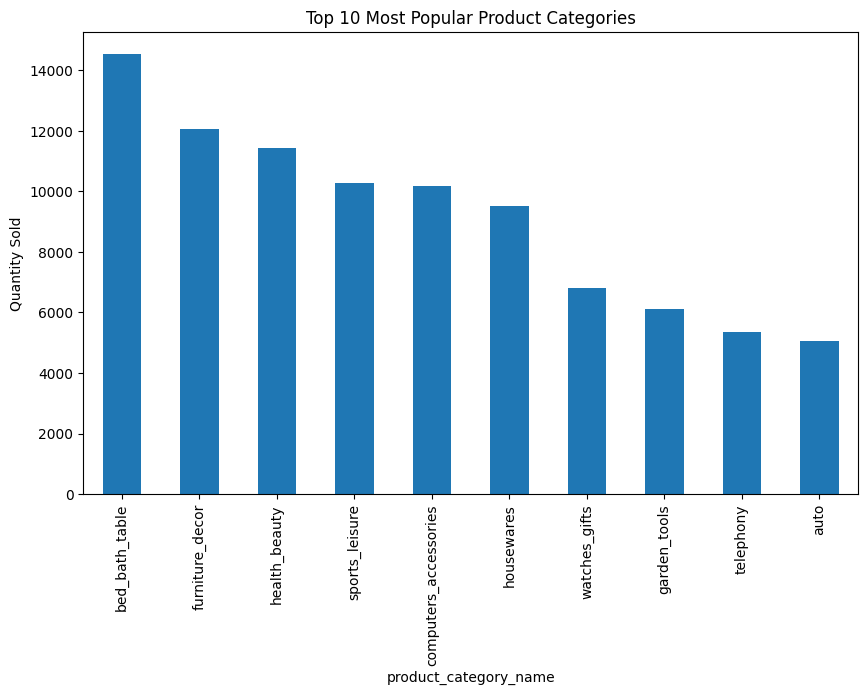

In [46]:
popular_products = df_merged.groupby('product_category_name')['order_item_id'].sum().sort_values(ascending=False)
print(popular_products.head())

plt.figure(figsize=(10, 6))
popular_products.head(10).plot(kind='bar')
plt.title('Top 10 Most Popular Product Categories')
plt.ylabel('Quantity Sold')
plt.show()

### Q2: What are the preferred payment methods?
We can see that the leading payment method in Brazil is a credit card with over 70% of customers using it, followed by Boleto - a cash-based payment method in Brazil. The least used method is a debit card, probably due to security considerations.

payment_type
boleto         19.454569
credit_card    73.764323
debit_card      1.435880
voucher         5.345229
dtype: float64


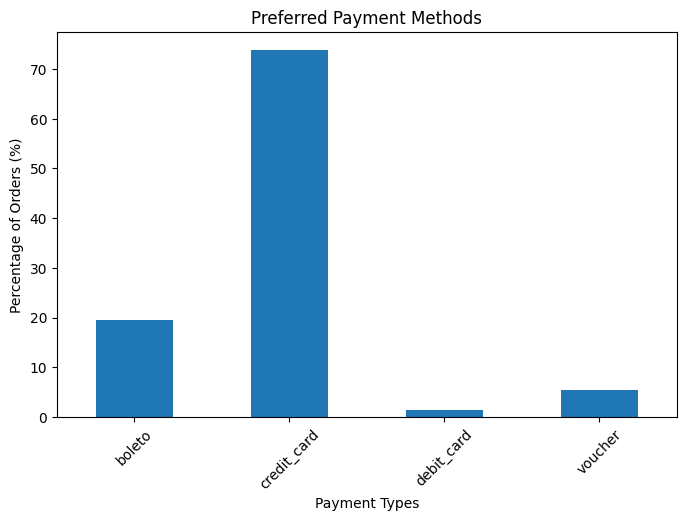

In [47]:
preferred_payment_methods = df_merged.groupby('payment_type').size()
total = preferred_payment_methods.sum()
preferred_payment_methods_pct = (preferred_payment_methods / total) * 100
print(preferred_payment_methods_pct)

preferred_payment_methods_pct.plot(kind='bar', figsize=(8, 5))
plt.title('Preferred Payment Methods')
plt.ylabel('Percentage of Orders (%)')
plt.xlabel('Payment Types')
plt.xticks(rotation=45)
plt.show()

### Q3: Order Flows Across Different States
The largest share of the order flow in Brazil seems to be within **Sao Paulo** (SP), and most of the sellers dispatch the orders from this location as well. The second and third common locations of the customers are **Minas Gerais** (MG) and **Rio de Janeiro** (RJ), and of the sellers - **Minas Gerais** (MG) and **Parana** (PR).

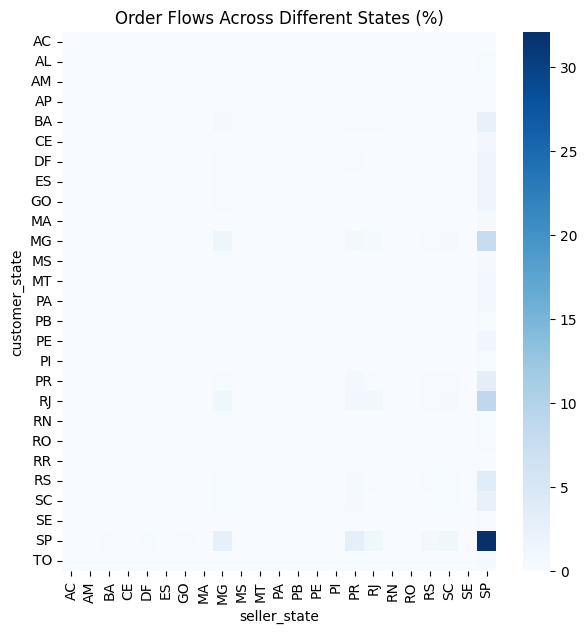

In [48]:
order_flows = df_merged.groupby(['customer_state', 'seller_state']).size().unstack().fillna(0)
total = order_flows.sum().sum()
order_flows_pct = (order_flows / total) * 100

plt.figure(figsize=(7, 7))
sns.heatmap(order_flows_pct, cmap='Blues', annot=False)  
plt.title('Order Flows Across Different States (%)')
plt.show()

### Q4: Delivery Times
From the delivery times for different product categories, we can note that the **office furniture** takes the longest to deliver (~20 days), while **craftmanship, kitchen tool, book and children clothes** are delivered much faster (5-8 days).
We also observe that the delivery seems to be the **fastest for the three states where most sellers are located - SP, MG, PR.**

product_category_name
agro_industry_and_commerce    11.508130
air_conditioning              11.846939
art                           10.734300
arts_and_craftmanship          5.291667
audio                         12.846561
Name: delivery_time, dtype: float64
customer_state
AC    20.170213
AL    24.138322
AM    26.100592
AP    27.662651
BA    18.721628
Name: delivery_time, dtype: float64


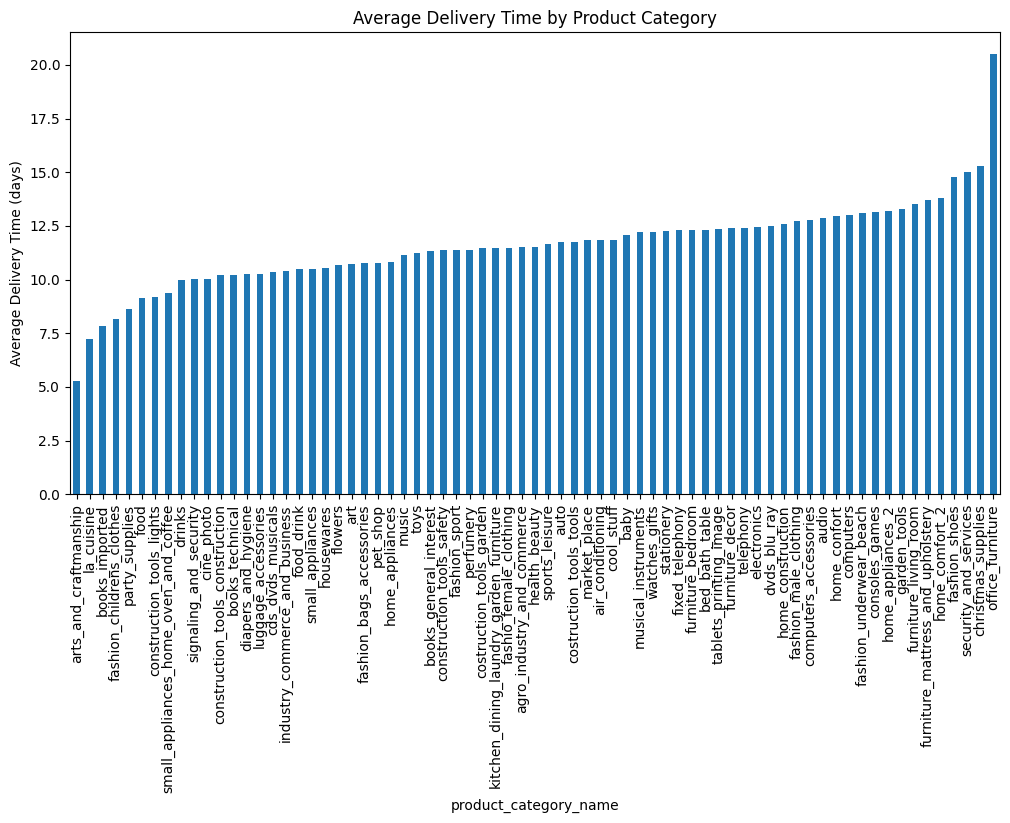

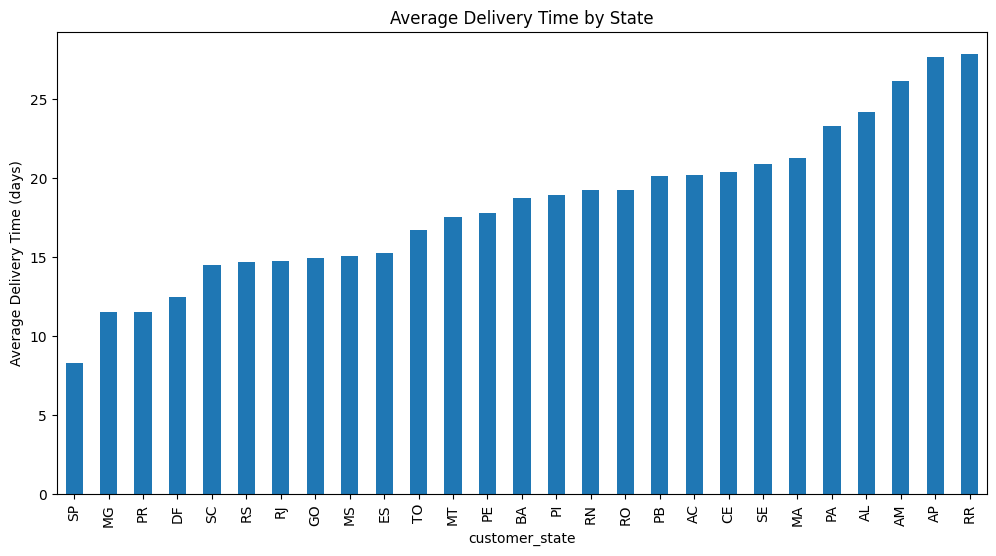

In [49]:
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
df_merged['order_delivered_customer_date'] = pd.to_datetime(df_merged['order_delivered_customer_date'])

df_merged['delivery_time'] = (df_merged['order_delivered_customer_date'] - df_merged['order_purchase_timestamp']).dt.days

avg_delivery_time_by_category = df_merged.groupby('product_category_name')['delivery_time'].mean()
avg_delivery_time_by_state = df_merged.groupby('customer_state')['delivery_time'].mean()

print(avg_delivery_time_by_category.head())
print(avg_delivery_time_by_state.head())

avg_delivery_time_by_category.sort_values().plot(kind='bar', figsize=(12, 6))
plt.title('Average Delivery Time by Product Category')
plt.ylabel('Average Delivery Time (days)')
plt.show()

avg_delivery_time_by_state.sort_values().plot(kind='bar', figsize=(12, 6))
plt.title('Average Delivery Time by State')
plt.ylabel('Average Delivery Time (days)')
plt.show()


From the first plot above it may seem that the item delivery time heavily depends on its size - the smaller, the faster the delivery. However, by diving deeper and checking **how strong the correlation between item volume (dimensions), weight and delivery time** is, we can see that although larger items tend to be heavier (80% correlation coefficient), we cannot claim that heavier or larger products tend to be delivered with much difference to smaller and light ones:

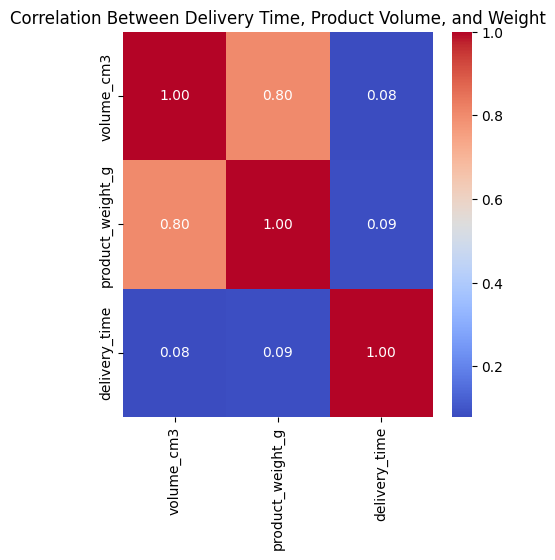

In [50]:
correlation_data = df_merged[['volume_cm3', 'product_weight_g', 'delivery_time']]
delivery_corr = correlation_data.corr()

plt.figure(figsize=(5,5))
sns.heatmap(delivery_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Delivery Time, Product Volume, and Weight')
plt.show()

### Q5: Item Description Length
And now let's check whether the items that are bought the most tend to have longer or shorter descriptions. We will group description lengths into unequal bins based on how frequent each length group appears in the data to find patterns.

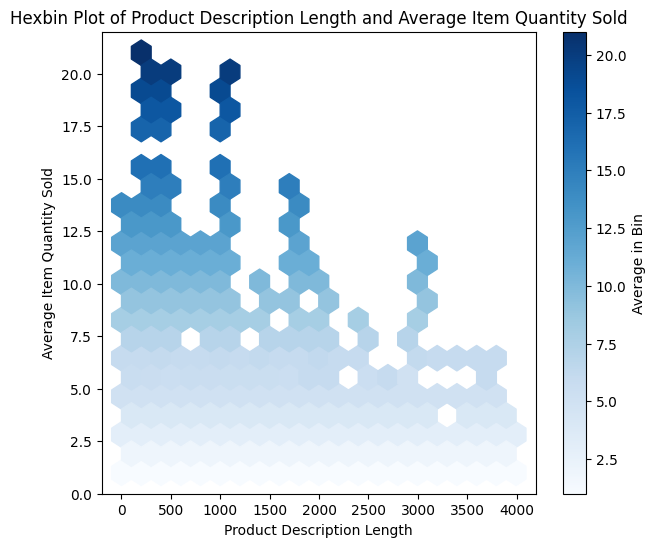

In [51]:
correlation_description_sales = df_merged[['order_item_id', 'product_description_length']].corr()
plt.figure(figsize=(7, 6))
plt.hexbin(data=df_merged, x='product_description_length', y='order_item_id', C=df_merged['order_item_id'], 
           gridsize=20, cmap='Blues', reduce_C_function=np.mean)
cb = plt.colorbar(label='Average in Bin')
plt.title('Hexbin Plot of Product Description Length and Average Item Quantity Sold')
plt.xlabel('Product Description Length')
plt.ylabel('Average Item Quantity Sold')
plt.show()

From the plot below we see that indeed items with descriptions under 1000 symbols tend to be sold more often on average. However, there is a simple explanation for it: the items with short descriptions might also be cheaper, and items with long descriptions (such as computers) might be more expensive, and bought less often.

### Q6: Freight value by product category

Looking into which categories have the heighest freight value, we see that computers have the highest average price declared for transportation, followed by home appliances (electronics) and furtniture.

Is this because such products have higher price in general? Turns out that is not the only factor - although there is a 0.41 correlation coefficient between freight value and price, there is an even higher correlation of freight value and volume or weight (0.61, 0.59). So the products with the highest freight value tend to have a higher price, weigh more and have larger dimensions.

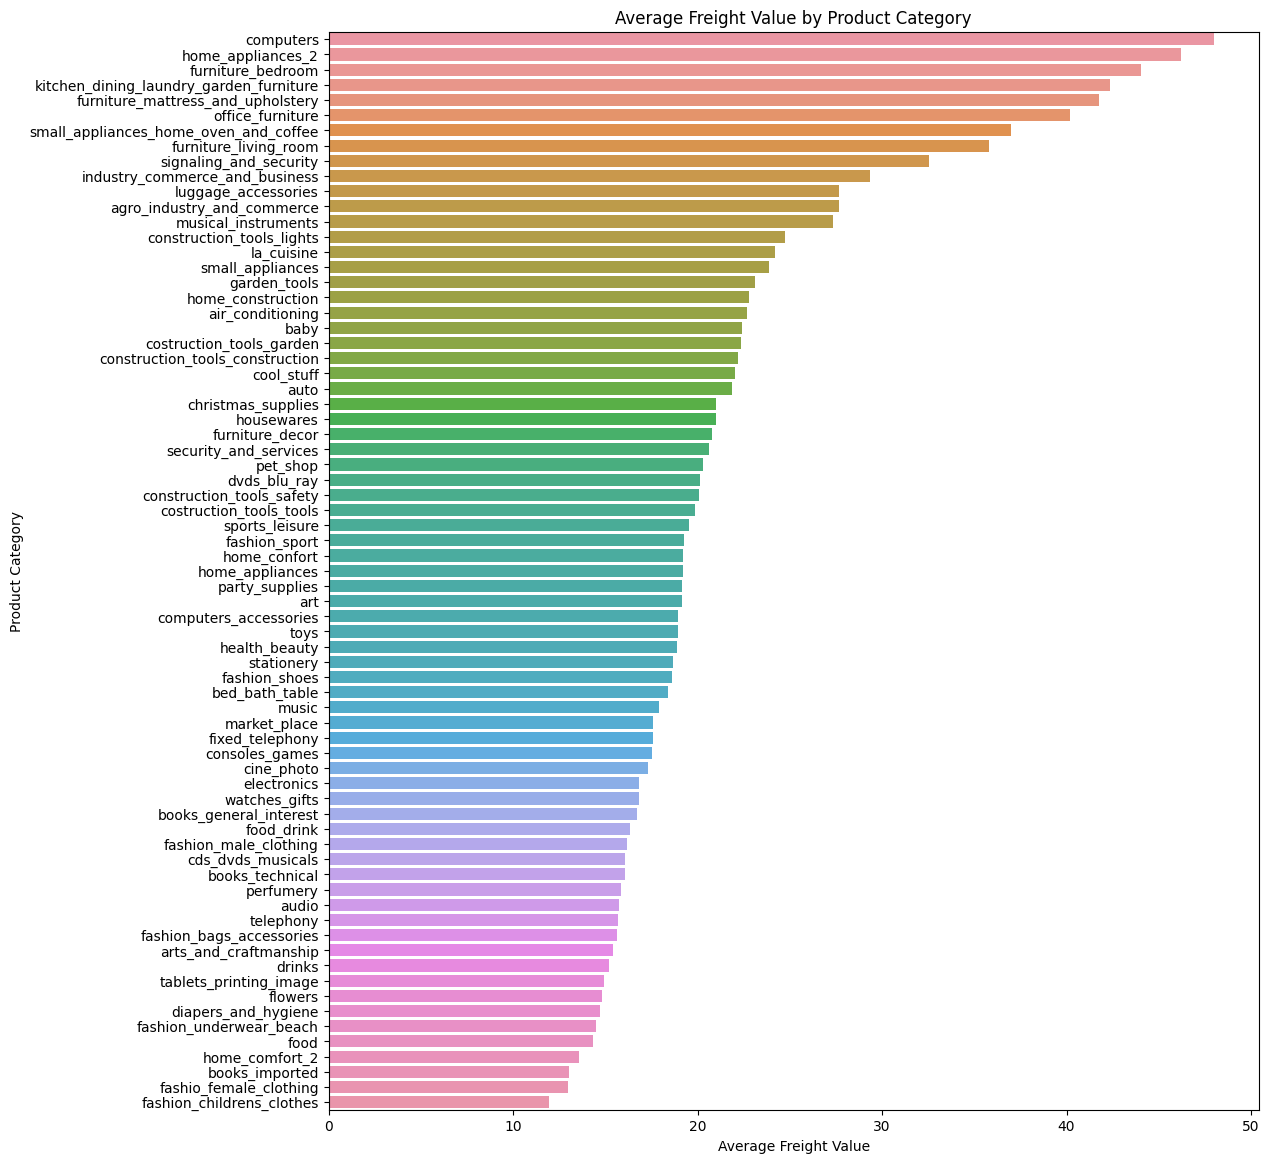

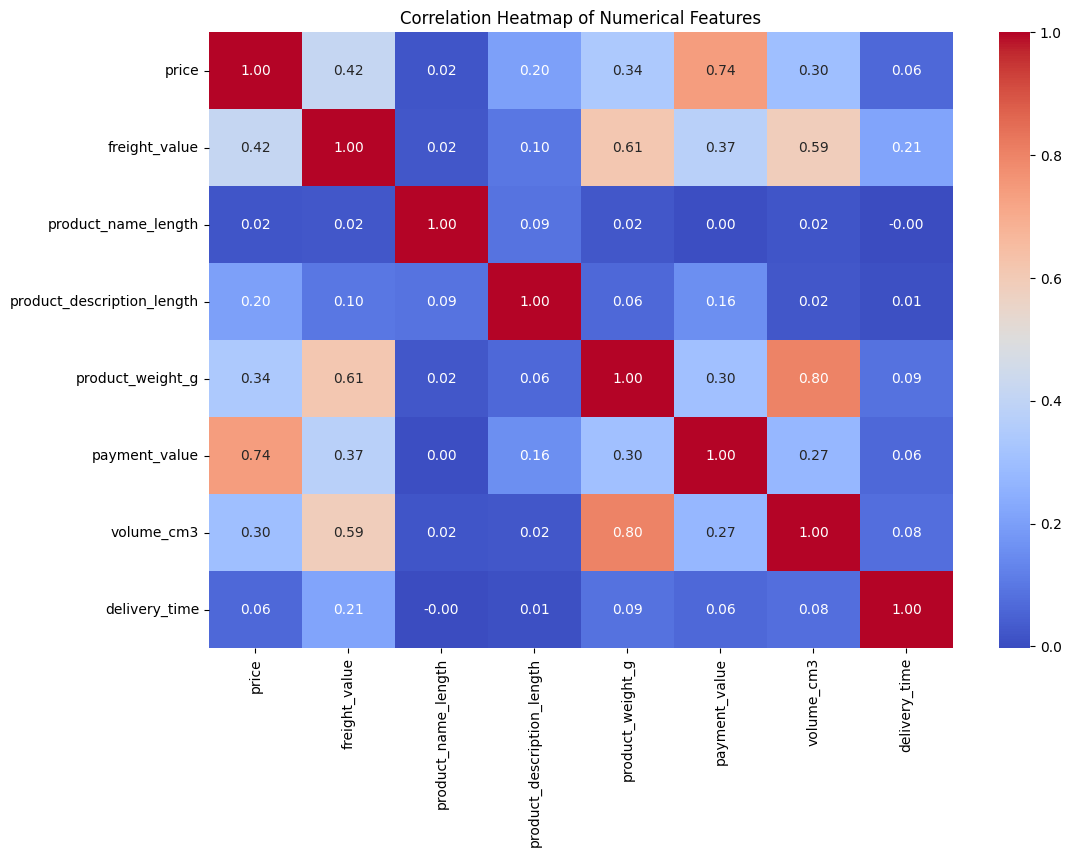

In [52]:
average_freight_by_category = df_merged.groupby('product_category_name')['freight_value'].mean().reset_index()
average_freight_by_category = average_freight_by_category.sort_values(by='freight_value', ascending=False)
plt.figure(figsize=(12, 14))
sns.barplot(data=average_freight_by_category, 
            x='freight_value', 
            y='product_category_name', 
            orient='h', 
            order=average_freight_by_category['product_category_name'])
plt.title('Average Freight Value by Product Category')
plt.xlabel('Average Freight Value')
plt.ylabel('Product Category')
plt.show()


corr = df_merged[['price', 'freight_value', 'product_name_length', 'product_description_length', 'product_weight_g', 'payment_value', 'volume_cm3', 'delivery_time']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Q7: Monthly sales by Spending category

From the plot below we can notice that September, October, and December have the lowest sales by all spending categories. It also looks like most of the sales every month are made in the high spending category - probably since there are so many popular categories with furniture and appliancies. Perhaps those are the types of goods customers prefer to order online.

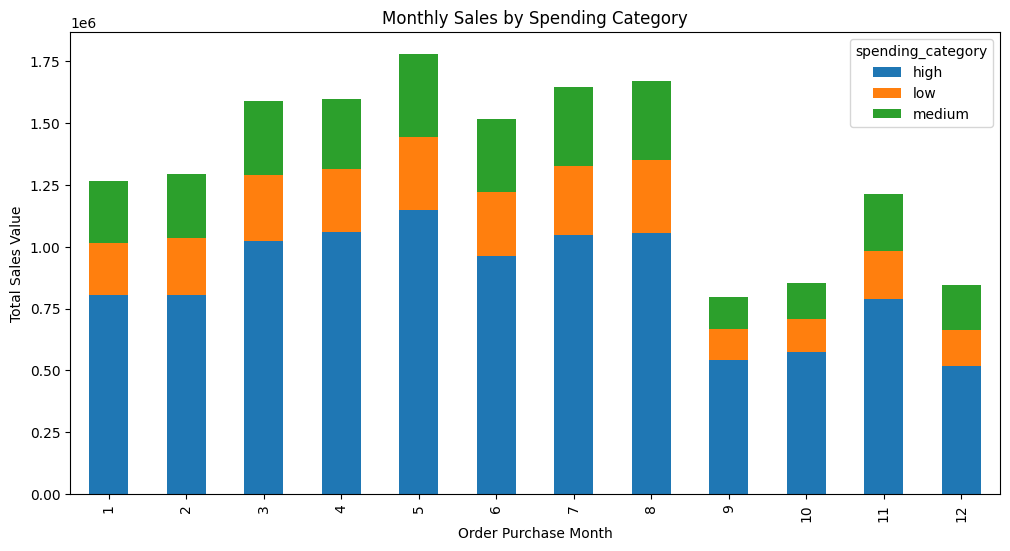

In [53]:
monthly_sales = df_merged.groupby(['order_purchase_month', 'spending_category'])['sales_value'].sum().unstack().reset_index()

monthly_sales.plot(kind='bar', stacked=True, x='order_purchase_month', figsize=(12,6))
plt.title('Monthly Sales by Spending Category')
plt.xlabel('Order Purchase Month')
plt.ylabel('Total Sales Value')
plt.show()

### Insights on the Map
Finally, let's check how some of the metrics are distributed on the map of Brazil.

#### Average Delivery Time by State
From the map below we can see that the average delivery time to the customer differs by state and is on average from 10 to 25 days. WE can also note that the fastest deliveries happen in the states where most of the sellers are located - SP, PR, MG. And the further the other states are from these three, the longer it takes to deliver the order to the customer.

In [54]:
df_merged['delivery_time'] = (pd.to_datetime(df_merged['order_delivered_customer_date']) - pd.to_datetime(df_merged['order_estimated_delivery_date'])).dt.days
df_merged['total_delivery_time'] = (pd.to_datetime(df_merged['order_delivered_customer_date']) - pd.to_datetime(df_merged['order_purchase_timestamp'])).dt.days
total_sales_value = df_merged.groupby('customer_state')['sales_value'].sum().reset_index()
average_freight_value = df_merged.groupby('customer_state')['freight_value'].mean().reset_index()
average_total_delivery_time = df_merged.groupby('customer_state')['total_delivery_time'].mean().reset_index()

geojson_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"

fig1 = px.choropleth(average_total_delivery_time, 
                     geojson=geojson_url, 
                     locations='customer_state', 
                     featureidkey="properties.sigla",
                     color='total_delivery_time',
                     title="Average Total Delivery Time by State in Brazil")
fig1.update_geos(fitbounds="locations")
fig1.show()

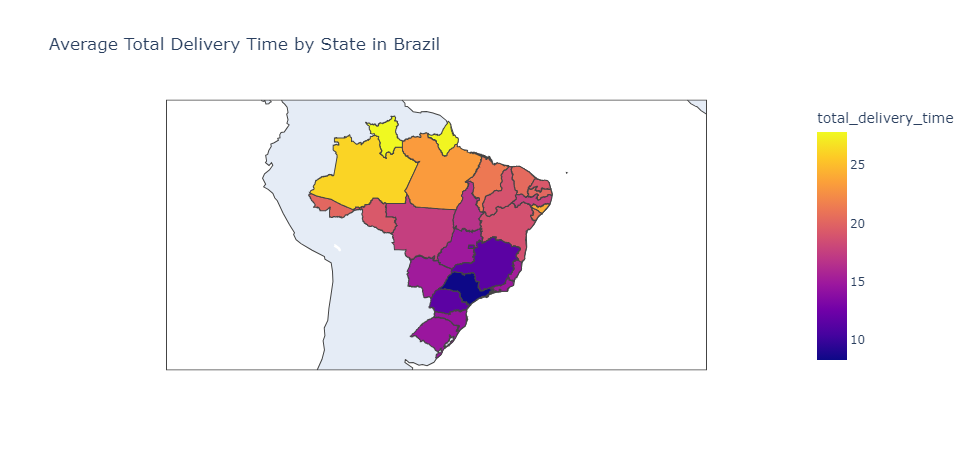

In [55]:
from PIL import Image
im = Image.open("DeliveryTimeMap.png")
im.show()

#### Total Sales Value by State
To see which regions of Brasil do the most online purchases, let's visualize the number of orders by state. Most of the orders are made by clients in Sao Paulo and nearby states.

In [56]:
fig2 = px.choropleth(total_sales_value, 
                     geojson=geojson_url, 
                     locations='customer_state', 
                     featureidkey="properties.sigla",
                     color='sales_value',
                     title="Total Sales Value by State in Brazil")
fig2.update_geos(fitbounds="locations")
fig2.show()

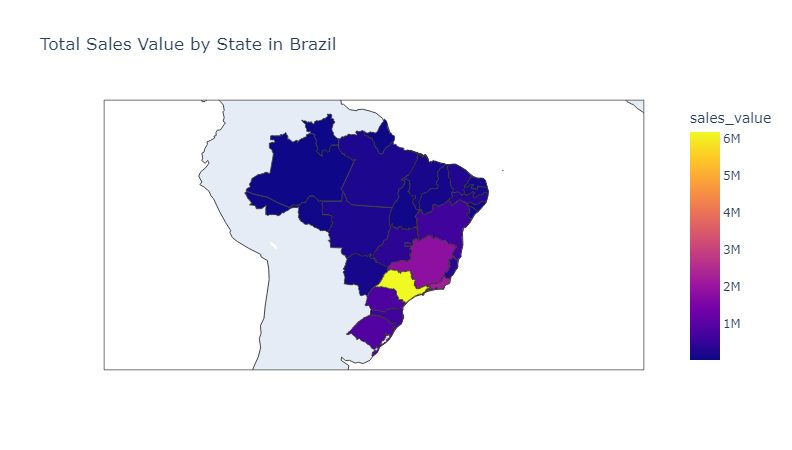

In [57]:
im = Image.open("OrdersMap.png")
im.show()

#### Average Freight Value by State
As for the freight value, we can see that unlike the delivery time, the further the states are from Sao Paulo, the higher the freight value is. There could be several explanations for this. For instance,  since most of the sellers are near SP, it makes sense to state a higher freight value to insure the delivery in case something happens on the way. On the other hand, it can also be that the customers from the further states tend to shop online for major or expensive items like appliances, computers and so on, and buy cheaper goods locally.

In [58]:
fig3 = px.choropleth(average_freight_value, 
                     geojson=geojson_url, 
                     locations='customer_state', 
                     featureidkey="properties.sigla",
                     color='freight_value',
                     title="Average Freight Value by State in Brazil")
fig3.update_geos(fitbounds="locations")
fig3.show()

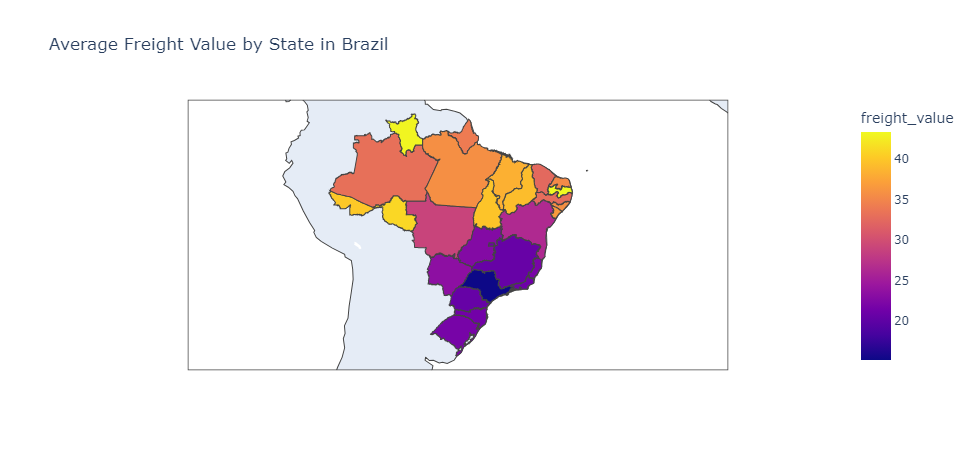

In [59]:
im = Image.open("FreightValueMap.png")
im.show()